In [88]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.constants import c, R_jup, M_jup, G, GM_jup, sigma_sb, M_sun, L_sun
import astropy.units as u
from scipy.interpolate import interp1d, interp2d
import cmocean

from matplotlib import rc
rc('font', family='times new roman', size=22.)

In [ ]:
def heat(temp, R, epsilon=1):
    return (4*np.pi*R**2*sigma_sb*temp**4*epsilon)

def temp(heat, R, epsilon=1):
    return np.power(heat/(4*np.pi*R**2*sigma_sb*epsilon), 0.25)

In [103]:
age  = {}
logL = {}
L    = {}
M    = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
Teff = {}
for mass in M:
    data = np.genfromtxt("../data/saumon_marley_fig2_" + str(mass) + ".dat", unpack=True)
    age[mass]  = data[0]
    logL[mass] = data[1]
    L[mass]    = np.power(10, data[1])*L_sun
    Teff[mass] = temp(L[mass], R_jup)

(6.0, 10.0)

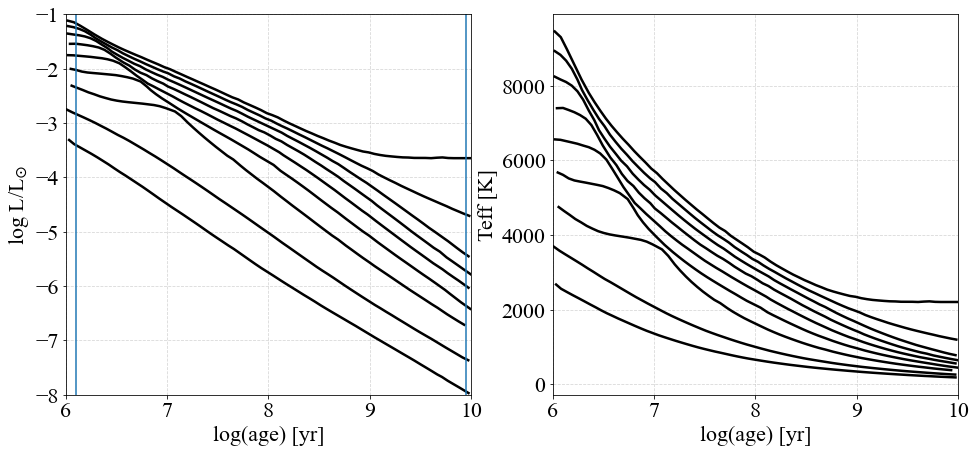

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

for mass in M:
    ax[0].plot(age[mass], logL[mass], color="k", lw=2.5)
    ax[1].plot(age[mass], Teff[mass], color="k", lw=2.5)

ax[0].set_ylabel("log L/L$_{\odot}$")
ax[0].set_xlabel("log(age) [yr]")
ax[0].grid(which="both", ls="--", alpha=0.5)
ax[0].set_ylim([-8, -1])
ax[0].set_xlim([6, 10])
ax[0].axvline(6.1)
ax[0].axvline(9.95)

ax[1].set_ylabel("Teff [K]")
ax[1].set_xlabel("log(age) [yr]")
ax[1].grid(which="both", ls="--", alpha=0.5)
ax[1].set_xlim([6, 10])

In [116]:
log_age  = np.linspace(6.1, 9.9, 10)
_log_age = []
_mass    = []
_teff    = []

for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for lage in log_age:
        _log_age.append(lage)
        _mass.append(m)
        _teff.append(Teff_interp(lage))

Teff_interp_2d = interp2d(_log_age, _mass, _teff)
_teff = np.asarray(_teff)

Text(0.5, 0, 'log(age) [yr]')

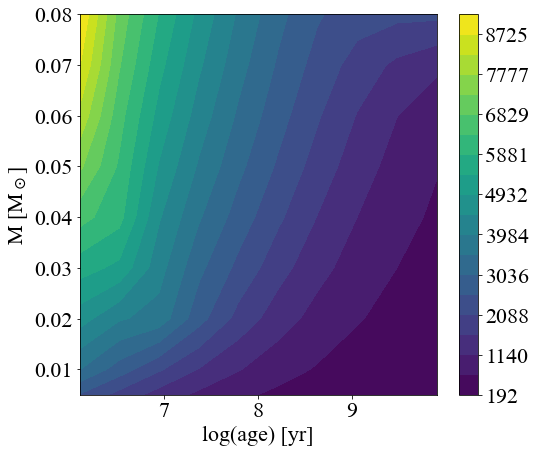

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

Z = _teff.reshape(len(M), len(log_age))

X, Y = np.meshgrid(log_age, M)

levels = np.linspace(np.min(_teff), np.max(_teff), 20)

cs = ax.contourf(X, Y, Z, levels=levels)
cbar = fig.colorbar(cs)

ax.set_ylabel("M [M$_\odot$]")
ax.set_xlabel("log(age) [yr]")

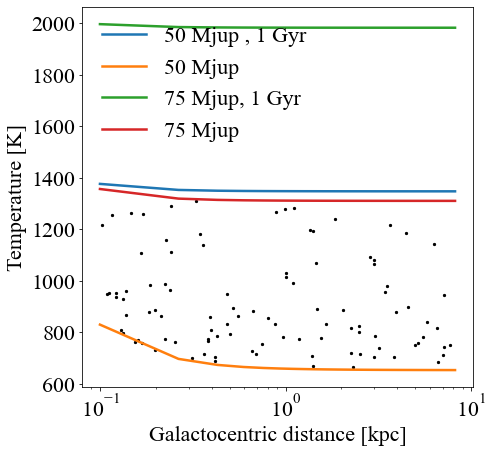

In [190]:
import numpy as np
from scipy.stats import loguniform
from scipy.interpolate import interp1d, interp2d
from astropy.constants import L_sun, R_jup, M_jup, M_sun
import sys
sys.path.append("../python/")
from utils import temperature, heat, temperature_withDM

# generation of mock catalog
np.random.seed(42)
# Number of simulated exoplanets
N = 100
# galactocentric radius of simulated exoplanets
r_obs = loguniform.rvs(0.1, 8.178, size=N)
# load theoretical BD cooling model taken from Saumon & Marley '08 (fig 2)
age  = {}
logL = {}
L    = {}
M    = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
Teff = {}

# TODO simplify by directly interpolating on heating/luminosity
for mass in M:
    data = np.genfromtxt("../data/saumon_marley_fig2_" + str(mass) + ".dat", 
                         unpack=True)
    age[mass]  = data[0]
    heat_int   = np.power(10, data[1])*L_sun.value
    Teff[mass] = temperature(heat_int, R_jup)
log_age  = np.linspace(6.1, 9.92, 10)
_log_age = []
_mass    = []
_teff    = []
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for lage in log_age:
        _log_age.append(lage)
        _mass.append(m)
        _teff.append(Teff_interp(lage))
# effective temperature (wo DM heating) vs log(age) and mass exoplanet
Teff_interp_2d = interp2d(_log_age, _mass, _teff)
del age, logL, L, M, Teff, _log_age, _mass, _teff
# Ages and masses of simulated BDs
log_ages = np.random.uniform(9.89, 9.92, N) # [yr] / [1-10 Gyr]
mass     = np.random.uniform(50, 75, N)
mass     = mass*M_jup/M_sun # [Msun]
heat_int = np.zeros(N)
for i in range(N):
    heat_int[i] = heat(Teff_interp_2d(log_ages[i], mass[i]), R_jup.value)

# TODO check t_obs calculation is correct
t_obs = temperature_withDM(r_obs, heat_int, f=1, R=R_jup.value, 
                           M=mass*M_sun.value, parameters=[1, 20, 0.42])
#t_obs = t_obs + 0.1*np.random.normal(loc=0, scale=(0.1*t_obs), size=N)


fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(r_obs, t_obs, color="k", s=5)
#ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Temperature [K]")
ax.set_xlabel("Galactocentric distance [kpc]")


r = np.linspace(0.1, 8.178, 50)
m = 50.*M_jup; l_age = 9.
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="50 Mjup , 1 Gyr", lw=2.5)

m = 50.*M_jup; l_age = 9.92
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="50 Mjup", lw=2.5)

m = 75.*M_jup; l_age = 9.
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="75 Mjup, 1 Gyr", lw=2.5)

m = 75.*M_jup; l_age = 9.92
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="75 Mjup", lw=2.5)

ax.legend(frameon=False)

In [187]:
print(Teff_interp_2d(9, 75*M_jup/M_sun))
print(Teff_interp_2d(9.92, 75*M_jup/M_sun))

[1982.48176479]
[1310.19724026]
